In [3]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lamiacolab","key":"7ddebe8001c1f8037dfe2bbc70729f43"}'}

In [5]:
import os
import zipfile

# Make kaggle folder and move json file
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


In [6]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone


Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
ct-kidney-dataset-normal-cyst-tumor-and-stone.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip


Archive:  ct-kidney-dataset-normal-cyst-tumor-and-stone.zip
replace CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1).jpg  
replace CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
!pip install split-folders
!pip install imutils
!pip install pydot
!pip install graphviz
!pip install opencv-python
!pip install scikit-learn

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
import splitfolders
import cv2
import random
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imutils import paths

In [8]:
import os
import cv2
import numpy as np
from imutils import paths
from tqdm import tqdm
import random

inputFolder = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
segmentedFolder = '/kaggle/working/CT_dataset'
IMGSIZE = 128
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']
random.seed(42)

if not os.path.exists(segmentedFolder):
    os.makedirs(segmentedFolder)

# Apply watershed segmentation to each image
for class_folder in os.listdir(inputFolder):
    class_path = os.path.join(inputFolder, class_folder)
    output_class_path = os.path.join(segmentedFolder, class_folder)
    os.makedirs(output_class_path, exist_ok=True)

    for image_name in tqdm(os.listdir(class_path), desc=f"Processing {class_folder}"):
        img_path = os.path.join(class_path, image_name)
        image = cv2.imread(img_path)

        if image is None:
            continue  # Skip if image can't be read

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)

        # Binary threshold
        _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Morphological operations
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        sure_bg = cv2.dilate(opening, kernel, iterations=3)

        # Distance transform
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

        # Unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)

        # Marker labeling
        _, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0

        # Apply watershed
        markers = cv2.watershed(image, markers)
        image[markers == -1] = [255, 0, 0]  # boundary in red

        # Resize before saving (this is the key addition)
        segmented = cv2.resize(image, (IMGSIZE, IMGSIZE))

        # Save the segmented image
        save_path = os.path.join(output_class_path, image_name)
        cv2.imwrite(save_path, segmented)


Processing Stone:  61%|██████▏   | 844/1377 [00:15<00:09, 53.72it/s]


KeyboardInterrupt: 

In [ ]:
from imutils import paths

segmentedFolder = '/kaggle/working/CT_dataset'  # or wherever your segmented data is
imgPaths = list(paths.list_images(segmentedFolder))


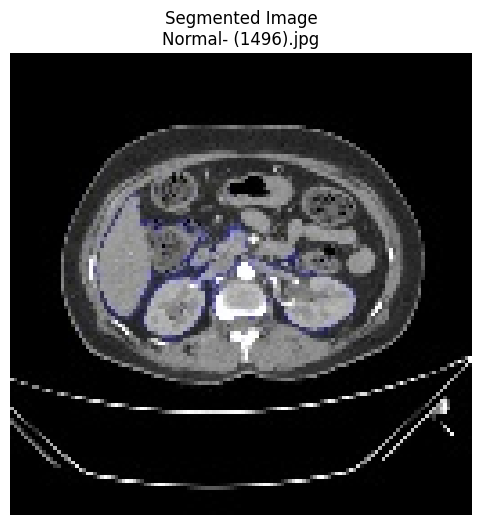

In [ ]:
import cv2
import random
import matplotlib.pyplot as plt
from imutils import paths

# Path to segmented images
segmentedFolder = '/kaggle/working/CT_dataset'

# Get all image paths from segmented dataset
imgPaths = list(paths.list_images(segmentedFolder))

# Pick a random image
sample_path = random.choice(imgPaths)

# Read the segmented image
segmented_img = cv2.imread(sample_path)

# Display image
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
plt.title(f"Segmented Image\n{os.path.basename(sample_path)}")
plt.axis('off')
plt.show()


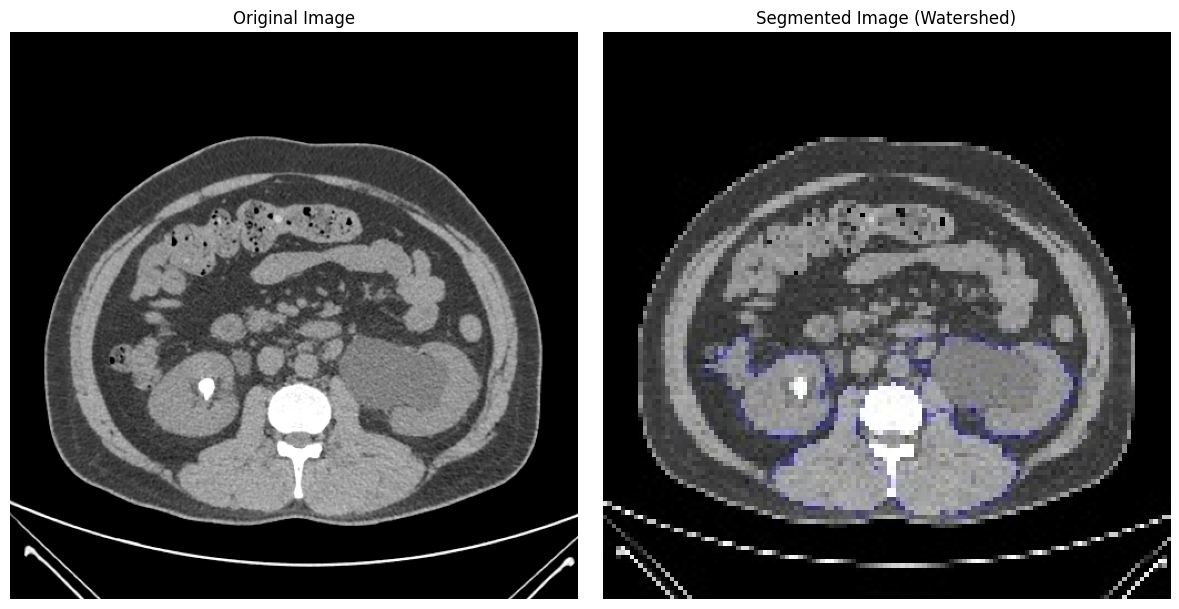

In [ ]:
import cv2
import os
import random
import matplotlib.pyplot as plt
from imutils import paths

# Paths
originalFolder = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
segmentedFolder = '/kaggle/working/CT_dataset'

# Get all segmented image paths
segmented_imgPaths = list(paths.list_images(segmentedFolder))

# Pick a random segmented image
segmented_path = random.choice(segmented_imgPaths)

# Extract class name and image name
parts = segmented_path.split(os.path.sep)
class_name = parts[-2]
image_name = parts[-1]

# Get corresponding original image path
original_path = os.path.join(originalFolder, class_name, image_name)

# Load both images
original_img = cv2.imread(original_path)
segmented_img = cv2.imread(segmented_path)

# Convert to RGB for displaying
original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
segmented_rgb = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB)

# Display side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_rgb)
plt.title("Segmented Image (Watershed)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imutils import paths
import shutil

inputFolder = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
augmentedFolder = '/kaggle/working/CT_dataset'
IMGSIZE = 128
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']
random.seed(42)

# ---- AUGMENTATION SETUP ----
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# ---- CREATE AUGMENTED FOLDER STRUCTURE ----
if os.path.exists(augmentedFolder):
    shutil.rmtree(augmentedFolder)
shutil.copytree(inputFolder, augmentedFolder)

# ---- AUGMENT EACH CLASS ----
for class_folder in os.listdir(inputFolder):
    class_path = os.path.join(inputFolder, class_folder)
    aug_class_path = os.path.join(augmentedFolder, class_folder)

    if not os.path.isdir(class_path):
        continue

    imagePaths = list(paths.list_images(class_path))

    for imgPath in imagePaths:
        img = cv2.imread(imgPath)
        img = cv2.resize(img, (224, 224))  # You can change IMGSIZE if needed

        img_array = np.expand_dims(img, 0)  # Make it 4D

        prefix = os.path.splitext(os.path.basename(imgPath))[0]

        # Generate 3 augmentations per image
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=aug_class_path,
                                  save_prefix=f"{prefix}_aug", save_format='jpg'):
            i += 1
            if i >= 3:
                break


In [11]:
import os

segmentedFolder = '/kaggle/working/CT_dataset'
total_images = 0

for class_folder in os.listdir(segmentedFolder):
    class_path = os.path.join(segmentedFolder, class_folder)
    if os.path.isdir(class_path):
        num_images = len([file for file in os.listdir(class_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"{class_folder}: {num_images} images")
        total_images += num_images

print(f"\nTotal images in segmented dataset: {total_images}")


Cyst: 14836 images
Stone: 5507 images
Normal: 20307 images
Tumor: 9132 images

Total images in segmented dataset: 49782


In [12]:
outputFolder = '/kaggle/working/CT_dataset'
splitfolders.ratio(augmentedFolder, outputFolder, seed=42, ratio=(0.8, 0.0, 0.2))
imgPaths = list(paths.list_images(outputFolder))
random.shuffle(imgPaths)


Copying files: 49782 files [00:09, 5163.66 files/s]


In [13]:
x_train, y_train, x_test, y_test = [], [], [], []

for imgPath in imgPaths:
    trainOrTest = imgPath.split('/')[-3]
    className = imgPath.split('/')[-2]

    img = cv2.imread(imgPath)
    img = cv2.resize(img, (IMGSIZE, IMGSIZE))

    if trainOrTest == 'train':
        x_train.append(img)
        y_train.append(classes.index(className))
    elif trainOrTest == 'test':
        x_test.append(img)
        y_test.append(classes.index(className))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

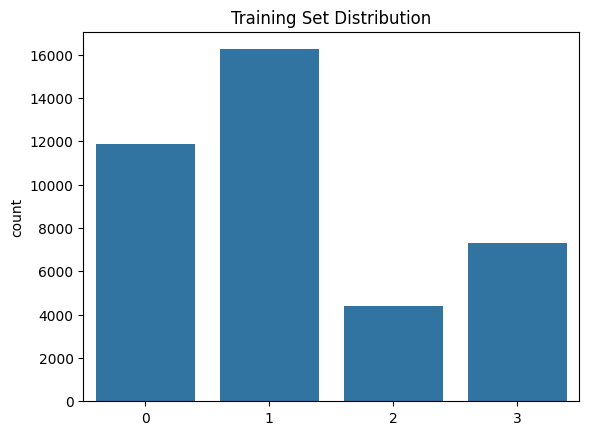

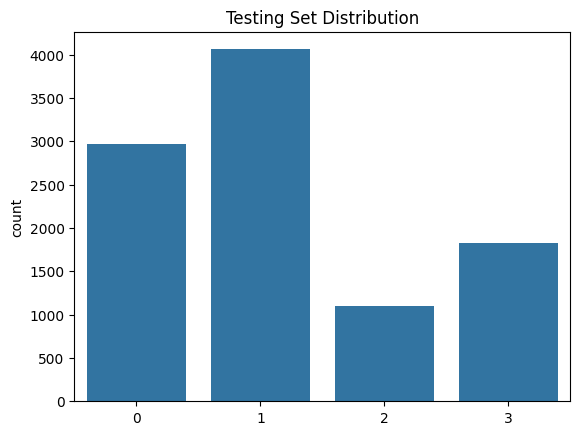

In [14]:
sb.countplot(x=y_train)
plt.title("Training Set Distribution")
plt.show()

sb.countplot(x=y_test)
plt.title("Testing Set Distribution")
plt.show()

In [1]:
x_train = (x_train / 255.0).astype('float32')
x_test = (x_test / 255.0).astype('float32')

# Compute Class Weights (for imbalanced data)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}


NameError: name 'x_train' is not defined

In [16]:
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Assuming x_train, x_test, y_train, y_test are already loaded as NumPy arrays

# Define batch size
BATCH_SIZE = 16  # Adjust based on your system's memory

# Function to normalize images
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Apply normalization, shuffle, and batch
train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# Apply normalization and batch
test_ds = test_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Compute Class Weights (for imbalanced data)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

# Compute Class Weights (for imbalanced data)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

In [17]:
def build_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMGSIZE, IMGSIZE, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test, model_name):
    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        epochs=30,
        class_weight=class_weights,
        batch_size=32
    )

    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Plot Training History
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Confusion Matrix and Metrics
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=classes))
    print(f"{model_name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.5178 - loss: 4.9014 - val_accuracy: 0.7492 - val_loss: 0.6033
Epoch 2/25
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.7671 - loss: 0.5974 - val_accuracy: 0.8066 - val_loss: 0.4828
Epoch 3/25
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.8336 - loss: 0.4342 - val_accuracy: 0.8276 - val_loss: 0.4409
Epoch 4/25
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.8784 - loss: 0.3249 - val_accuracy: 0.8681 - val_loss: 0.3358
Epoch 5/25
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9038 - loss: 0.2576 - val_accuracy: 0.8805 - val_loss: 0.3256
Epoch 6/25
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.9263 - loss: 0.2074 - val_accuracy: 0.9006 - val_loss: 0.2668
Epoch 7/25
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.9384 - loss: 0.1718 - val_accuracy: 0.9295 - val_loss: 0.1933
Epoch 8/25
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9493 -

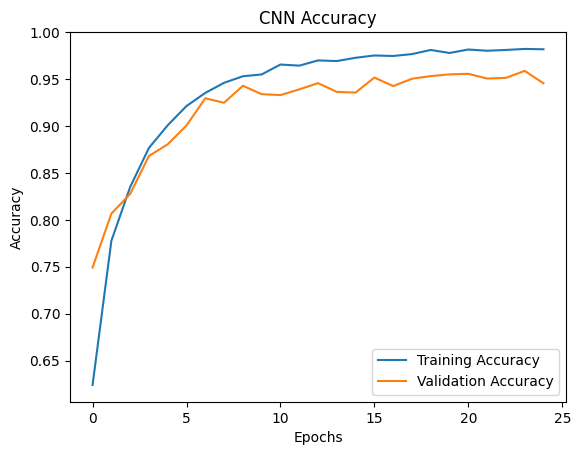

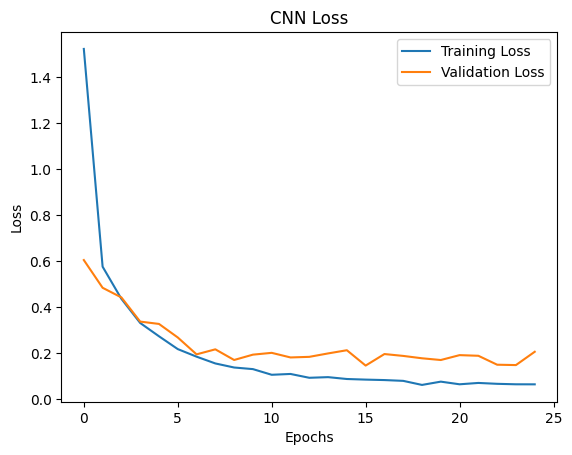

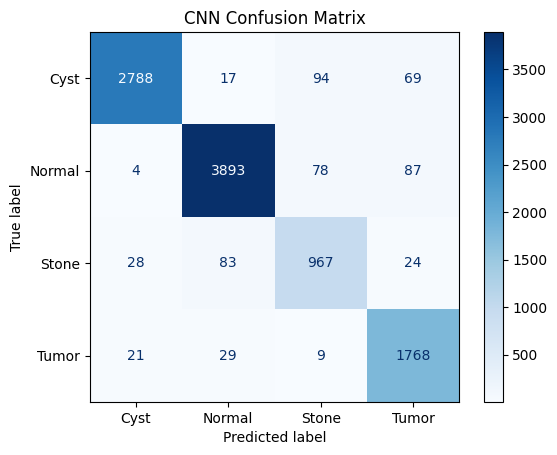

CNN Classification Report:
              precision    recall  f1-score   support

        Cyst       0.98      0.94      0.96      2968
      Normal       0.97      0.96      0.96      4062
       Stone       0.84      0.88      0.86      1102
       Tumor       0.91      0.97      0.94      1827

    accuracy                           0.95      9959
   macro avg       0.92      0.94      0.93      9959
weighted avg       0.95      0.95      0.95      9959

CNN Accuracy: 0.9455


In [19]:
cnn = build_cnn()
train_and_evaluate_model(cnn, x_train, y_train, x_test, y_test, "CNN")